In [ ]:
from google.colab import drive
drive.mount('/content/drive')
 
# 본인이 파일 업로드 한 폴더로 경로 지정
%cd /content/drive/My Drive/wavve
 
## 주요 라이브러리 import
 
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from dateutil.relativedelta import relativedelta
from datetime import *

Mounted at /content/drive
/content/drive/My Drive/wavve


In [ ]:
ds_service = "train_service.csv"
df_service = pd.read_csv(ds_service, parse_dates=['registerdate','enddate'], infer_datetime_format=True)
 
# 시청 이력(train_bookmark) 데이터 읽기 : 전체 412,036 rows
ds_bookmark = "train_bookmark.csv"
df_bookmark = pd.read_csv(ds_bookmark, parse_dates=['dates'], infer_datetime_format=True)
 
ds_coin = 'coin.csv'
df_coin = pd.read_csv(ds_coin, parse_dates=['registerdate'], infer_datetime_format=True)

In [ ]:
ds_service_test = "predict_service.csv"
df_service_test = pd.read_csv(ds_service_test, parse_dates=['registerdate','enddate'], infer_datetime_format=True)
 
ds_bookmark_test = "predict_bookmark.csv"
df_bookmark_test = pd.read_csv(ds_bookmark_test, parse_dates=['dates'], infer_datetime_format=True)
 
ds_coin_test = 'coin.csv'
df_coin_test = pd.read_csv(ds_coin_test, parse_dates=['registerdate'], infer_datetime_format=True)

In [ ]:
def preprocess(df_service, df_bookmark, df_coin, train=True, scale=False, a_label_encoder_map=None, a_scaler=None):
    df_service = df_service.copy()
    df_bookmark = df_bookmark.copy()
    df_coin = df_coin.copy()
 
    # gender null 값을 N 으로 변경 후 확인
    df_service.fillna({'gender':'N'}, inplace=True)
 
    #### agegroup
 
    # 0살은 잘못 측정
    df_service.loc[ (df_service['agegroup'] == 0), 'agegroup'] = np.nan
    # 인증안받은 40대는 잘못 측정
    df_service.loc[ (df_service['agegroup'] == 40) & (df_service['isauth'] != 'Y'), 'agegroup'] = np.nan
 
    df_service['agegroup2'] = df_service['agegroup']
 
    df_service.loc[ (df_service['agegroup'] >= 60), 'agegroup2'] = 6
    df_service.loc[ (df_service['agegroup'] >= 45) & (df_service['agegroup'] < 60), 'agegroup2'] = 5
    df_service.loc[ (df_service['agegroup'] >= 35) & (df_service['agegroup'] < 45), 'agegroup2'] = 4
    df_service.loc[ (df_service['agegroup'] >= 25) & (df_service['agegroup'] < 35), 'agegroup2'] = 3
    df_service.loc[ (df_service['agegroup'] >= 15) & (df_service['agegroup'] < 25), 'agegroup2'] = 2
    df_service.loc[ (df_service['agegroup'] < 15), 'agegroup2'] = 1
    # 결측치 0으로
    df_service.fillna({'agegroup2':0}, inplace=True)
    df_service['agegroup'] = df_service['agegroup2']
    df_service.drop('agegroup2', axis=1, inplace=True)
 
    #### pgamount
 
    # pgamount 금액 중에 달러로 결제된 것 원화로 변경 (pgamount 100원 미만인 건은 Appstore에서 달러 결제 건임)
    df_service.loc[(df_service['pgamount'] <  100), 'pgamount'] = df_service['pgamount'] * 1120
    
    df_service['pgamountgroup'] = df_service['pgamount']
    # 7900, 10900, 13900 이 기본상품인듯
    # flo, bugs와의 조합형 상품은 13750
    # 그룹을 5개로 나눈다. 100, 100 < <= 7900, 7900 < <= 10900, 10900 < <= 13900, 13900 <
    df_service.loc[ (df_service['pgamount'] == 100), 'pgamountgroup'] = '1'
    df_service.loc[ (df_service['pgamount'] > 100) & (df_service['pgamount'] <= 7900), 'pgamountgroup'] = '2'
    df_service.loc[ (df_service['pgamount'] > 7900) & (df_service['pgamount'] <= 10900), 'pgamountgroup'] = '3'
    df_service.loc[ (df_service['pgamount'] > 10900) & (df_service['pgamount'] <= 13900), 'pgamountgroup'] = '4'
    df_service.loc[ (df_service['pgamount'] > 13900), 'pgamountgroup'] = '5'
 
    df_service['pgamount'] = df_service['pgamountgroup']
    df_service.drop(['pgamountgroup'], axis=1, inplace=True)
    
    # 기타 컬럼들의 결측치 처리
    df_service.fillna('X', inplace=True)
 
    # 변수 생성(Feature Extraction) (예시)
    # (1) 고객별 서비스 가입 이력 수
    df_feature_1 = df_service.groupby(by='uno', as_index=False).registerdate.count()
    df_feature_1.rename(columns={'registerdate':'REG_CNT'}, inplace=True)
 
    # (2) 고객별 서비스 가입 이력 상품 수
    df_feature_2 = df_service[['uno','productcode']]
    df_feature_2 = df_feature_2.drop_duplicates() # 고객별 동일 상품 제거
    df_feature_2 = df_feature_2.groupby(by='uno', as_index=False).productcode.count()
    df_feature_2.rename(columns={'productcode':'PRD_CNT'}, inplace=True)
 
    # (3) 고객별 시청 건수 (1시간 단위)
    df_feature_3 = df_bookmark.groupby(by='uno', as_index=False).dates.count()
    df_feature_3.rename(columns={'dates':'BM_CNT'}, inplace=True)
 
    # (4) 고객별 시청 총 시간
    df_feature_4 = df_bookmark.groupby(by='uno', as_index=False).viewtime.sum()
    df_feature_4.rename(columns={'viewtime':'VT_TOT'}, inplace=True)
    df_feature_4['VT_TOT'] = df_feature_4['VT_TOT'] / 3600
 
    # (5) 고객별 시청 평균 시간
    df_feature_5 = df_bookmark.groupby(by='uno', as_index=False).viewtime.mean()
    df_feature_5.rename(columns={'viewtime':'VT_AVG'}, inplace=True)
    df_feature_5['VT_AVG'] = df_feature_5['VT_AVG'] / 3600
 
    # (6) 고객별 시청 채널 수
    df_feature_6 = df_bookmark[['uno','channeltype']]
    df_feature_6 = df_feature_6.drop_duplicates() # 고객별 동일 채널 제거
    df_feature_6 = df_feature_6.groupby(by='uno', as_index=False).channeltype.count()
    df_feature_6.rename(columns={'channeltype':'CH_CNT'}, inplace=True)
 
    # (7) 고객별 시청 프로그램 수
    df_feature_7 = df_bookmark[['uno','programid']]
    df_feature_7 = df_feature_7.drop_duplicates() # 고객별 동일 프로그램 제거
    df_feature_7 = df_feature_7.groupby(by='uno', as_index=False).programid.count()
    df_feature_7.rename(columns={'programid':'PRG_CNT'}, inplace=True)
 
    # (8) 고객별 시청 디바이스 수
    df_feature_8 = df_bookmark[['uno','devicetype']]
    df_feature_8 = df_feature_8.drop_duplicates() # 고객별 동일 프로그램 제거
    df_feature_8 = df_feature_8.groupby(by='uno', as_index=False).devicetype.count()
    df_feature_8.rename(columns={'devicetype':'DEV_CNT'}, inplace=True)
 
    # (9) movie 또는 contents 종류 별 건수
    df_feature_9 = df_bookmark[(df_bookmark['channeltype'] == 'V')].groupby(by='uno', as_index=False).dates.count()
    df_feature_9.rename(columns={'dates':'V_CNT'}, inplace=True)
 
    df_feature_10 = df_bookmark[(df_bookmark['channeltype'] == 'M')].groupby(by='uno', as_index=False).dates.count()
    df_feature_10.rename(columns={'dates':'M_CNT'}, inplace=True)
 
    df_feature_11 = df_bookmark[(df_bookmark['channeltype'] == 'L')].groupby(by='uno', as_index=False).dates.count()
    df_feature_11.rename(columns={'dates':'L_CNT'}, inplace=True)


 
    ''' L일때는 채널코드인데 채널보다 장르가 더 상세한 레벨의 성향을 유추할 수 있다. 무시
    df_feature_10 = df_bookmark[df_bookmark['channeltype'] == 'L'].groupby(by=['uno','programid']).dates.count()
    df_feature_10 = df_feature_10.unstack()
    '''
 
    ''' 절대 다수가 0이라서 무시
    df_feature_11 = df_bookmark[df_bookmark['channeltype'] == 'E'].groupby(by=['uno','channeltype']).dates.count()
    df_feature_11 = df_feature_11.unstack()
    '''
 
    def group_device_type(device_type):
        if device_type == 1:
            return 'DEV_PC'
        elif device_type in (2,4,8):
            return 'DEV_MOBILE'
        elif device_type in (3,5):
            return 'DEV_TABLET'        
        elif device_type in (6,12,21,27,32,72):
            return 'DEV_TV'            
        elif device_type in (7,71,73,74,75,76,77,78,79,80,81):
            return 'DEV_OTT'
        else:
            return 'DEV_ETC'
 
    # device type 별 시청 횟수     
    df_feature_13 = df_bookmark[['uno','devicetype']]
    df_feature_13.loc[:, 'devicetype'] = df_feature_13['devicetype'].apply(group_device_type)
    df_feature_13 = df_feature_13.groupby(by=['uno','devicetype']).devicetype.count()
    df_feature_13 = df_feature_13.unstack()
    
    # 코인 충전 금액
    df_charge = df_coin[ (df_coin.paymenttypeid == 1) | (df_coin.paymenttypeid == 3) ].groupby(by='uno', as_index=False).totalamount.sum()
    df_charge.rename(columns={'totalamount':'charge_amount'}, inplace=True)
 
    # 코인 충전 금액(실구매금액)
    df_charge_pg = df_coin[ (df_coin.paymenttypeid == 1) | (df_coin.paymenttypeid == 3) ].groupby(by='uno', as_index=False).pgamount.sum()
    df_charge_pg.rename(columns={'pgamount':'charge_pg'}, inplace=True)
 
    # 구매한 컨텐츠 금액(원금)
    df_contents_amount = df_coin[df_coin.paymenttypeid == 2].groupby(by='uno', as_index=False).totalamount.sum()
    df_contents_amount.rename(columns={'totalamount':'contents_amount'}, inplace=True)
 
    # 구매한 컨텐츠 금액 중 coin
    df_contents_amount_coin = df_coin.groupby(by='uno', as_index=False).coinamount.sum()
    df_contents_amount_coin.rename(columns={'coinamount':'contents_amount_coin'}, inplace=True)    
 
    # 구매한 컨텐츠 금액(실구매금액)
    df_contents_amount_pg = df_coin[df_coin.paymenttypeid == 2].groupby(by='uno', as_index=False).pgamount.sum()
    df_contents_amount_pg.rename(columns={'pgamount':'contents_amount_pg'}, inplace=True)
 
    #  구매한 컨텐츠 건수
    df_contents_count = df_coin[df_coin.paymenttypeid == 2].groupby(by='uno', as_index=False).pgamount.count()
    df_contents_count.rename(columns={'pgamount':'contents_count'}, inplace=True)
 
    #  부분 취소 건수
    df_cancel_count = df_coin[df_coin.paymenttypeid == 9].groupby(by='uno', as_index=False).totalamount.count()
    df_cancel_count.rename(columns={'totalamount':'cancel_count'}, inplace=True)
 
    #  부분 취소 금액
    df_cancel_amount = df_coin[df_coin.paymenttypeid == 9].groupby(by='uno', as_index=False).totalamount.sum()
    df_cancel_amount.rename(columns={'totalamount':'cancel_amount'}, inplace=True)
 
 
    df_feature_12 = df_bookmark[(df_bookmark['channeltype'] == 'V') | (df_bookmark['channeltype'] == 'M')].groupby(by=['uno','section']).dates.count()
    df_feature_12 = df_feature_12.unstack()
    section_columns_map = {
        '1'  : '드라마', 
        '2'  : '예능',
        '3'  : '시사교양',
        '4'  : '뉴스',
        '5'  : '스포츠',
        '6'  : '키즈',
        '7'  : '라디오',
        '8'  : '애니메이션1',
        '9'  : '해외시리즈',
        '10' : '해외다큐',
        '11' : '홈쇼핑',
        '12' : '크리에이터',
        'M01': '드라마/가족',       #
        'M02': '로맨스/멜로',
        'M03': '코미디',
        'M04': '액션/모험',
        'M05': 'SF/판타지',
        'M06': '공포/스릴러',
        'M07': '애니메이션2',       #
        'M08': '기타',
        'M90': '성인',
    }
    df_feature_12.rename(columns=section_columns_map, inplace=True)

    df_svc_target = df_service
    
    # 해지 예측 대상 서비스에 생성한 변수 연결
    #df_svc_target = pd.merge(df_svc_target, df_feature_1, on='uno', how='left')
    #df_svc_target = pd.merge(df_svc_target, df_feature_2, on='uno', how='left')
    df_svc_target = pd.merge(df_svc_target, df_feature_3, on='uno', how='left')
    df_svc_target = pd.merge(df_svc_target, df_feature_4, on='uno', how='left')
    df_svc_target = pd.merge(df_svc_target, df_feature_5, on='uno', how='left')
    df_svc_target = pd.merge(df_svc_target, df_feature_6, on='uno', how='left')
    df_svc_target = pd.merge(df_svc_target, df_feature_7, on='uno', how='left')
    df_svc_target = pd.merge(df_svc_target, df_feature_8, on='uno', how='left')
    df_svc_target = pd.merge(df_svc_target, df_feature_9, on='uno', how='left')
    df_svc_target = pd.merge(df_svc_target, df_feature_10, on='uno', how='left')
    df_svc_target = pd.merge(df_svc_target, df_feature_11, on='uno', how='left')
    df_svc_target = pd.merge(df_svc_target, df_feature_13, on='uno', how='left')
    df_svc_target = pd.merge(df_svc_target, df_charge, on='uno', how='left')
    df_svc_target = pd.merge(df_svc_target, df_charge_pg, on='uno', how='left')
    df_svc_target = pd.merge(df_svc_target, df_contents_amount, on='uno', how='left')
    df_svc_target = pd.merge(df_svc_target, df_contents_amount_coin, on='uno', how='left')
    df_svc_target = pd.merge(df_svc_target, df_contents_amount_pg, on='uno', how='left')
    df_svc_target = pd.merge(df_svc_target, df_contents_count, on='uno', how='left')
    df_svc_target = pd.merge(df_svc_target, df_cancel_count, on='uno', how='left')
    df_svc_target = pd.merge(df_svc_target, df_cancel_amount, on='uno', how='left')
    df_svc_target = pd.merge(df_svc_target, df_feature_12, on='uno', how='left')    
    
    # 추가 생성 컬럼들의 결측치 처리
    df_svc_target.fillna(0, inplace=True)
    
    if 'DEV_ETC' in df_svc_target.columns:
        df_svc_target.drop('DEV_ETC', axis=1, inplace=True)
 
    df_svc_target['charge_remain'] = df_svc_target['charge_amount'] + df_svc_target['contents_amount_coin']
 
    #df_svc_target['총시청건수'] = df_svc_target['드라마'] + df_svc_target['예능'] + df_svc_target['시사교양'] + df_svc_target['뉴스'] + df_svc_target['스포츠'] + df_svc_target['키즈'] + df_svc_target['애니메이션1'] + df_svc_target['해외시리즈'] + df_svc_target['해외다큐'] + df_svc_target['크리에이터'] + df_svc_target['로맨스/멜로'] + df_svc_target['코미디'] + df_svc_target['공포/스릴러'] + df_svc_target['기타'] + df_svc_target['성인'] + df_svc_target['액션/모험'] + df_svc_target['SF/판타지'] + df_svc_target['드라마/가족'] + df_svc_target['애니메이션2']
    
    df_svc_target = df_svc_target.astype({'agegroup':'int', 'pgamount':'int'})
 
    '''
    df_svc_target = df_svc_target.astype({'BM_CNT':'int', 'CH_CNT':'int', 'PRG_CNT':'int', 'DEV_CNT':'int', 'V_CNT':'int', 'M_CNT':'int', 'L_CNT':'int',
                                          'DEV_PC':'int', 'DEV_MOBILE':'int', 'DEV_TABLET':'int', 'DEV_TV':'int', 'DEV_OTT':'int', 'agegroup':'int', 'pgamount':'int',
                                          'charge_remain':'int', 'charge_remain_pg':'int', 'contents_amount':'int', 'contents_amount_pg':'int', 'contents_count':'int'})
    '''                                          
    '''
                                          , 'charge_remain':'int'   
                                          '드라마':'int', '예능':'int', '시사교양':'int', '뉴스':'int', '스포츠':'int',
                                          '키즈':'int','애니메이션1':'int','해외시리즈':'int','해외다큐':'int',
                                          '크리에이터':'int','드라마/가족':'int','로맨스/멜로':'int','코미디':'int',
                                          '액션/모험':'int','SF/판타지':'int','공포/스릴러':'int','애니메이션2':'int','기타':'int','성인':'int',
                                          '홈쇼핑':'int','라디오':'int'
                                          '총시청건수':'int'
    '''
 
 
    #df_svc_target.drop(['드라마','예능','시사교양','뉴스','스포츠','키즈','애니메이션1','해외시리즈','해외다큐','크리에이터','드라마/가족','로맨스/멜로','코미디','액션/모험','SF/판타지','공포/스릴러','기타','성인','드라마/가족','애니메이션2'], axis=1, inplace=True)
 
    df_svc_target['CHURN'] = np.where(df_svc_target.Repurchase == 'X', 1, 0)   # 재결제('O') -> Churn Negative(0), 미결제('X') -> Churn Positive(1)
 
    # date관련 컬럼은 훈련에 아무 도움 안됨. 결제수단도 딱히.. devicetypeid는 결제기기인데 역시 딱히.. productcode는 가격과 밀접한 연관이 있어서 무시
    #df_svc_target.drop(['chargetypeid', 'devicetypeid', 'productcode', 'Repurchase',], axis=1, inplace=True)
    df_svc_target.drop(['chargetypeid', 'devicetypeid', 'Repurchase',], axis=1, inplace=True)

    col_lst = ['promo_100', 'coinReceived', 'isauth', 'gender'] 
    if train:
        label_encoder_map = {}
        for c in col_lst:
            lbl = LabelEncoder()
            lbl.fit(list(df_svc_target[c].values))
            df_svc_target[c] = lbl.transform(df_svc_target[c].values)
            label_encoder_map[c] = lbl                
    else:
        label_encoder_map = a_label_encoder_map
        for c in col_lst:
            lbl = label_encoder_map[c]
            df_svc_target[c] = lbl.transform(df_svc_target[c].values)

    # 해지 예측 대상 서비스 추출
    # 즉, 예측시점(가입일+3주)에 해지하지 않은 서비스 추출
    df_svc_target = df_svc_target[df_svc_target.enddate >= df_svc_target.registerdate + pd.DateOffset(weeks=3)]
 
    #df_svc_target.drop(['registerdate', 'enddate'], axis=1, inplace=True)
    df_svc_target.drop(['enddate'], axis=1, inplace=True)
    
    # agegroup, gender : onehotencode
    df_svc_target = pd.get_dummies(df_svc_target, columns=['gender', 'agegroup'])
 
    if scale:
        log_scale_columns = ['BM_CNT', 'VT_TOT', 'PRG_CNT', 'V_CNT', 'M_CNT', 'L_CNT', 
                             'DEV_MOBILE', 'DEV_OTT', 'DEV_PC', 'DEV_TABLET', 'DEV_TV', 'contents_count',
                             '드라마', '예능', '시사교양', '뉴스', '스포츠',
                             '키즈','애니메이션1','해외시리즈',#'해외다큐',
                             '크리에이터','드라마/가족','로맨스/멜로','코미디',
                             '액션/모험','SF/판타지','공포/스릴러','애니메이션2','기타',#'성인',
                             #'홈쇼핑','라디오'
                             ]
 
        scaled_values = np.log(df_svc_target[log_scale_columns].values + 1)
 
        for i, c in enumerate(log_scale_columns):
            df_svc_target.loc[:, c] = scaled_values[:,i]            
 
        min_max_scale_columns = ['charge_amount', 'charge_pg', 'contents_amount', 'contents_amount_coin', 
                                'contents_amount_pg', 'charge_remain', 'cancel_amount']                        
 
        if train:
            minmax_scaler = MinMaxScaler()               
            scaled_values = minmax_scaler.fit_transform(df_svc_target[min_max_scale_columns].values)
            for i, c in enumerate(min_max_scale_columns):
                df_svc_target.loc[:, c] = scaled_values[:,i]             
        else:
            minmax_scaler = a_scaler
            scaled_values = minmax_scaler.transform(df_svc_target[min_max_scale_columns].values)
            for i, c in enumerate(min_max_scale_columns):
                df_svc_target.loc[:, c] = scaled_values[:,i]             
        
        return df_svc_target, label_encoder_map, minmax_scaler                
    else:
        return df_svc_target, label_encoder_map#, std_scaler

In [ ]:
# 전체data, target data, label encoder (테스트셋에 적용)
#df_T, label_encoder_map = preprocess(df_service, df_bookmark, df_coin, False)
df_T, label_encoder_map, scaler = preprocess(df_service, df_bookmark, df_coin, True, True)

#df_T, label_encoder_map, scaler = preprocess(df_service, df_bookmark, df_coin, False, True)
 

 
df_T.info()
df_T.describe()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 69145 entries, 0 to 69707
Data columns (total 61 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   uno                   69145 non-null  object        
 1   registerdate          69145 non-null  datetime64[ns]
 2   productcode           69145 non-null  object        
 3   pgamount              69145 non-null  int64         
 4   concurrentwatchcount  69145 non-null  int64         
 5   promo_100             69145 non-null  int64         
 6   coinReceived          69145 non-null  int64         
 7   isauth                69145 non-null  int64         
 8   BM_CNT                69145 non-null  float64       
 9   VT_TOT                69145 non-null  float64       
 10  VT_AVG                69145 non-null  float64       
 11  CH_CNT                69145 non-null  float64       
 12  PRG_CNT               69145 non-null  float64       
 13  DEV_CNT         

,pgamount,concurrentwatchcount,promo_100,coinReceived,isauth,BM_CNT,VT_TOT,VT_AVG,CH_CNT,PRG_CNT,DEV_CNT,V_CNT,M_CNT,L_CNT,DEV_MOBILE,DEV_OTT,DEV_PC,DEV_TABLET,DEV_TV,charge_amount,charge_pg,contents_amount,contents_amount_coin,contents_amount_pg,contents_count,cancel_count,cancel_amount,드라마,해외다큐,크리에이터,예능,시사교양,뉴스,스포츠,키즈,애니메이션1,해외시리즈,드라마/가족,로맨스/멜로,코미디,액션/모험,SF/판타지,공포/스릴러,애니메이션2,기타,성인,charge_remain,CHURN,gender_0,gender_1,gender_2,agegroup_0,agegroup_1,agegroup_2,agegroup_3,agegroup_4,agegroup_5,agegroup_6
count,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000
mean,2.019813,1.691778,0.484966,0.819900,0.743394,1.242236,0.694364,0.202985,0.751435,0.693093,0.848926,1.144851,0.108033,0.105987,0.746334,0.046068,0.235024,0.228664,0.180768,0.012771,0.000212,0.001092,0.439513,0.000545,0.007409,0.033018,0.995227,0.634976,0.000016,0.000106,0.503053,0.104771,0.000420,0.000222,0.006932,0.036214,0.099879,0.034291,0.020448,0.010024,0.024849,0.019546,0.009556,0.011123,0.002157,0.000072,0.274795,0.315178,0.525548,0.310782,0.163671,0.209184,0.000043,0.155528,0.323610,0.173939,0.112749,0.024948
std,1.279194,1.088627,0.499778,0.384273,0.436763,1.158167,0.755288,0.203414,0.669008,0.649782,0.830144,1.130923,0.408889,0.430673,1.007148,0.318854,0.665741,0.656160,0.585672,0.047531,0.008714,0.017217,0.014380,0.016025,0.088963,0.183555,0.031640,0.911646,0.004178,0.011643,0.850019,0.402754,0.020464,0.016852,0.128997,0.295769,0.493330,0.221634,0.162205,0.108694,0.184181,0.169491,0.112204,0.123576,0.051159,0.007918,0.024867,0.464590,0.499350,0.462817,0.369979,0.406729,0.006587,0.362410,0.467856,0.379060,0.316287,0.155966
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.441134,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.269578,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000,1.000000,1.098612,0.525714,0.186995,1.000000,0.693147,1.000000,1.098612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.441134,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.269578,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,2.000000,1.000000,1.000000,1.000000,2.197225,1.208131,0.358333,1.000000,1.098612,1.000

In [ ]:
'''
unk_df = df_T[ (df_T['agegroup_0'] == 1) | (df_T.gender_2 == 1) ]
known_df = df_T[ (df_T['agegroup_0'] == 0) & (df_T.gender_2 == 0) ]
 
known_df.drop(['gender_2', 'agegroup_0'], axis=1, inplace=True)
known_df = df_T
'''

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:

'''
Log Transformer
  Helps with skewness
  No predetermined range for scaled data
  Useful only on non-zero, non-negative data
Min-Max Scaler
  Rescales to predetermined range [0–1]
  Doesn’t change distribution’s center (doesn’t correct skewness)
  Sensitive to outliers
Max Abs Scaler
  Rescales to predetermined range [-1–1]
  Doesn’t change distribution’s center
  Sensitive to outliers
Standard Scaler
  Shifts distribution’s mean to 0 & unit variance
  No predetermined range
  Best to use on data that is approximately normally distributed
Robust Scaler
  0 mean & unit variance
  Use of quartile ranges makes this less sensitive to (a few) outliers
  No predetermined range
Power Transformer
  Helps correct skewness
  0 mean & unit variance
  No predetermined range
  Yeo-Johnson or Box-Cox
  Box-Cox can only be used on non-negative data
'''
known_df

In [ ]:
# Basic correlation plot to understand which features are correlated
import matplotlib.pyplot as plt
import seaborn as sns
 
%matplotlib inline
 
plt.figure(figsize=(27,15))
sns.heatmap(known_df.corr(), annot=True)

In [ ]:
# Train/Test 데이터 분리 
X = df_T.drop(["uno","CHURN",'registerdate','productcode'], axis=1)
y = df_T["CHURN"]
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 111, stratify=y)

In [ ]:
X_train.describe()

,pgamount,concurrentwatchcount,promo_100,coinReceived,isauth,BM_CNT,VT_TOT,VT_AVG,CH_CNT,PRG_CNT,DEV_CNT,V_CNT,M_CNT,L_CNT,DEV_MOBILE,DEV_OTT,DEV_PC,DEV_TABLET,DEV_TV,charge_amount,charge_pg,contents_amount,contents_amount_coin,contents_amount_pg,contents_count,cancel_count,cancel_amount,드라마,해외다큐,크리에이터,예능,시사교양,뉴스,스포츠,키즈,애니메이션1,해외시리즈,드라마/가족,로맨스/멜로,코미디,액션/모험,SF/판타지,공포/스릴러,애니메이션2,기타,성인,charge_remain,gender_0,gender_1,gender_2,agegroup_0,agegroup_1,agegroup_2,agegroup_3,agegroup_4,agegroup_5,agegroup_6
count,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000,55316.000000
mean,2.016469,1.691210,0.482844,0.820106,0.744143,1.243317,0.694809,0.202989,0.751880,0.693353,0.849465,1.145761,0.108072,0.106169,0.747176,0.045810,0.233418,0.229157,0.181807,0.012797,0.000217,0.001079,0.439511,0.000599,0.007417,0.032396,0.995265,0.633878,0.000020,0.000133,0.504600,0.105163,0.000417,0.000173,0.006478,0.035397,0.101088,0.034575,0.020892,0.009649,0.024998,0.019303,0.009348,0.011099,0.002153,0.000077,0.274807,0.526249,0.309983,0.163768,0.208547,0.000036,0.156429,0.324481,0.172681,0.112463,0.025363
std,1.279406,1.088579,0.499710,0.384102,0.436346,1.157784,0.755660,0.203489,0.669307,0.648930,0.831338,1.130672,0.409520,0.430253,1.006557,0.318124,0.663494,0.657114,0.588075,0.047509,0.009012,0.017107,0.014208,0.017044,0.089118,0.181686,0.031789,0.910307,0.004671,0.013018,0.850658,0.404049,0.020579,0.014379,0.123991,0.293862,0.496690,0.223811,0.164312,0.107314,0.184287,0.168272,0.110942,0.124132,0.051198,0.008348,0.024855,0.499315,0.462490,0.370068,0.406274,0.006013,0.363264,0.468185,0.377974,0.315938,0.157228
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.441134,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.269578,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000,1.000000,1.098612,0.525714,0.186251,1.000000,0.693147,1.000000,1.098612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.441134,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.269578,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,2.000000,1.000000,1.000000,1.000000,2.197225,1.207301,0.358530,1.000000,1.098612,1.000000,2.079442,0.000000,0.000000,1.386294,0.000000,0.000000,0.0000

In [60]:
df_P, label_encoder_map, scaler = preprocess(df_service_test, df_bookmark_test, df_coin, False, True, label_encoder_map, scaler) 

predX = df_P.drop(["uno","CHURN",'registerdate','productcode'], axis=1)



predX.insert(28, '해외다큐', 0)
predX.insert(45, '성인', 0)

for c1, c2 in zip(predX.columns, X_train.columns):
    if c1 != c2:
        print("error!!!")

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
###
###        모델 학습 시 검증(평가) 지표 설정
###           ㅇ 본 경연의 평가 지표
###              - 1 순위 : F1
###              - 2 순위 : Accuracy
###
 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier
 
#got the best parameters above

parameters = {'learning_rate': [0.2], 
              'max_depth': [4],
              'min_child_weight': [4],
              'n_estimators': [50],
              'reg_alpha':[0],
              'gamma':[0.06],
              'subsample':[0.74],
              'colsample_bytree':[0.83]
              }
 
xgb = XGBClassifier(random_state=1, use_label_encoder=False, eval_metric='aucpr', objective='binary:logistic', n_jobs=-1)
 
from sklearn.metrics import f1_score, make_scorer


def f1_score_with_threshold(y_true, y_proba, threshold=0.5):
    return f1_score(y_true, (y_proba > threshold).astype(int))


f1 = make_scorer(f1_score_with_threshold, needs_proba=True, threshold=0.27)

#grid_obj_xgb = RandomizedSearchCV(xgb, parameters, cv=5, n_iter=100, scoring='f1_micro',verbose=5, n_jobs=-1)
#grid_obj_xgb = GridSearchCV(xgb, parameters, cv=1, scoring=f1, n_jobs=1, verbose=2)
#grid_obj_xgb.fit(X_train, y_train, verbose=0)
xgb = XGBClassifier(random_state=1, use_label_encoder=False, eval_metric='aucpr', objective='binary:logistic', n_jobs=-1,
                    learning_rate=0.2, max_depth=4, min_child_weight=4, n_estimators=50, reg_alpha=0, gamma=0.06, subsample=0.74, colsample_bytree=0.83)
xgb.fit(X, y, verbose=2)

#print(grid_obj_xgb.best_params_)
#print(grid_obj_xgb.best_score_)

 
'''
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
'''

'''
threshold -> 0.25

  'n_estimators': [50,100,200,300,400,500]
{'colsample_bytree': 0.8,
  'gamma': 0,
  'learning_rate': 0.2,
  'max_depth': 6,
  'min_child_weight': 9,
  'n_estimators': 50,
  'reg_alpha': 0,
  'subsample': 0.8},
 0.5248052829777993    

'n_estimators': [50]
 ({'colsample_bytree': 0.8,
  'gamma': 0,
  'learning_rate': 0.2,
  'max_depth': 5,
  'min_child_weight': 8,
  'n_estimators': 50,
  'reg_alpha': 0,
  'subsample': 0.8},
 0.5258972235681021,

 ({'colsample_bytree': 0.8,
  'gamma': 0.2,
  'learning_rate': 0.2,
  'max_depth': 5,
  'min_child_weight': 8,
  'n_estimators': 50,
  'reg_alpha': 0,
  'subsample': 0.8},
 0.5262920768503425)

 'gamma':[0.10, 0.15, 0.20, 0.25],
  ({'colsample_bytree': 0.8,
  'gamma': 0.2,
  'learning_rate': 0.2,
  'max_depth': 5,
  'min_child_weight': 8,
  'n_estimators': 50,
  'reg_alpha': 0,
  'subsample': 0.8},
 0.5262920768503425)

'subsample':[i/10.0 for i in range(6,10)],
'colsample_bytree':[i/10.0 for i in range(6,10)] 
  ({'colsample_bytree': 0.8,
  'gamma': 0.2,
  'learning_rate': 0.2,
  'max_depth': 5,
  'min_child_weight': 8,
  'n_estimators': 50,
  'reg_alpha': 0,
  'subsample': 0.8},
 0.5262920768503425)

'''
'''
드라마 등 추가하고 0.27
0.5241646513731629
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 50, 'reg_alpha': 0, 'subsample': 0.8}

({'colsample_bytree': 0.8,
  'gamma': 0,
  'learning_rate': 0.2,
  'max_depth': 4,
  'min_child_weight': 4,
  'n_estimators': 50,
  'reg_alpha': 0,
  'subsample': 0.8},
 0.5246003143287057)

gamma 0 ~ 0.5
 ({'colsample_bytree': 0.8,
  'gamma': 0.0,
  'learning_rate': 0.2,
  'max_depth': 4,
  'min_child_weight': 4,
  'n_estimators': 50,
  'reg_alpha': 0,
  'subsample': 0.8},
 0.5246003143287057)

 ({'colsample_bytree': 0.8,
  'gamma': 0.06,
  'learning_rate': 0.2,
  'max_depth': 4,
  'min_child_weight': 4,
  'n_estimators': 50,
  'reg_alpha': 0,
  'subsample': 0.8},
 0.5247064328300537)

estim 50 ~ 500
 ({'colsample_bytree': 0.8,
  'gamma': 0.06,
  'learning_rate': 0.2,
  'max_depth': 4,
  'min_child_weight': 4,
  'n_estimators': 50,
  'reg_alpha': 0,
  'subsample': 0.8},
 0.5247064328300537)

'subsample':[i/10.0 for i in range(6,10)],
'colsample_bytree':[i/10.0 for i in range(6,10)]
 ({'colsample_bytree': 0.8,
  'gamma': 0.06,
  'learning_rate': 0.2,
  'max_depth': 4,
  'min_child_weight': 4,
  'n_estimators': 50,
  'reg_alpha': 0,
  'subsample': 0.8},
 0.5247064328300537) 

'subsample':[i/100.0 for i in range(71,90)],
'colsample_bytree':[i/100.0 for i in range(71,90)] 

({'colsample_bytree': 0.83,
  'gamma': 0.06,
  'learning_rate': 0.2,
  'max_depth': 4,
  'min_child_weight': 4,
  'n_estimators': 50,
  'reg_alpha': 0,
  'subsample': 0.74},
 0.5259064992440526)

 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
 ({'colsample_bytree': 0.83,
  'gamma': 0.06,
  'learning_rate': 0.2,
  'max_depth': 4,
  'min_child_weight': 4,
  'n_estimators': 50,
  'reg_alpha': 0,
  'subsample': 0.74},
 0.5259064992440526)

 [0.01, 0.05, 0.1, 0.2, 0.3]
 ({'colsample_bytree': 0.83,
  'gamma': 0.06,
  'learning_rate': 0.2,
  'max_depth': 4,
  'min_child_weight': 4,
  'n_estimators': 50,
  'reg_alpha': 0,
  'subsample': 0.74},
 0.5259064992440526)
'''

"\n드라마 등 추가하고 0.27\n0.5241646513731629\n{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 50, 'reg_alpha': 0, 'subsample': 0.8}\n\n({'colsample_bytree': 0.8,\n  'gamma': 0,\n  'learning_rate': 0.2,\n  'max_depth': 4,\n  'min_child_weight': 4,\n  'n_estimators': 50,\n  'reg_alpha': 0,\n  'subsample': 0.8},\n 0.5246003143287057)\n\ngamma 0 ~ 0.5\n ({'colsample_bytree': 0.8,\n  'gamma': 0.0,\n  'learning_rate': 0.2,\n  'max_depth': 4,\n  'min_child_weight': 4,\n  'n_estimators': 50,\n  'reg_alpha': 0,\n  'subsample': 0.8},\n 0.5246003143287057)\n\n ({'colsample_bytree': 0.8,\n  'gamma': 0.06,\n  'learning_rate': 0.2,\n  'max_depth': 4,\n  'min_child_weight': 4,\n  'n_estimators': 50,\n  'reg_alpha': 0,\n  'subsample': 0.8},\n 0.5247064328300537)\n\nestim 50 ~ 500\n ({'colsample_bytree': 0.8,\n  'gamma': 0.06,\n  'learning_rate': 0.2,\n  'max_depth': 4,\n  'min_child_weight': 4,\n  'n_estimators': 50,\n  'reg_alpha': 0,\n  's

In [61]:
predX

,pgamount,concurrentwatchcount,promo_100,coinReceived,isauth,BM_CNT,VT_TOT,VT_AVG,CH_CNT,PRG_CNT,DEV_CNT,V_CNT,M_CNT,L_CNT,DEV_MOBILE,DEV_OTT,DEV_PC,DEV_TABLET,DEV_TV,charge_amount,charge_pg,contents_amount,contents_amount_coin,contents_amount_pg,contents_count,cancel_count,cancel_amount,드라마,해외다큐,크리에이터,예능,시사교양,뉴스,스포츠,키즈,애니메이션1,해외시리즈,드라마/가족,로맨스/멜로,코미디,액션/모험,SF/판타지,공포/스릴러,애니메이션2,기타,성인,charge_remain,gender_0,gender_1,gender_2,agegroup_0,agegroup_1,agegroup_2,agegroup_3,agegroup_4,agegroup_5,agegroup_6
0,1,1,0,1,1,2.302585,1.322496,0.305864,1.0,1.098612,2.0,2.302585,0.000000,0.0,1.791759,0.0,1.609438,0.000000,0.000000,0.000000,0.0,0.0,0.441134,0.0,0.0,0.0,1.000000,2.302585,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.269578,1,0,0,0,0,1,0,0,0,0
1,1,2,0,1,1,1.791759,0.739288,0.218889,1.0,1.098612,1.0,1.791759,0.000000,0.0,0.000000,0.0,1.791759,0.000000,0.000000,0.000000,0.0,0.0,0.441134,0.0,0.0,0.0,1.000000,0.000000,0,0.0,1.791759,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.269578,0,1,0,0,0,0,0,1,0,0
2,1,1,0,1,1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.441134,0.0,0.0,0.0,1.000000,0.000000,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.269578,0,1,0,0,0,0,0,1,0,0
3,3,2,1,1,0,2.197225,0.908483,0.185069,1.0,0.693147,2.0,2.197225,0.000000,0.0,1.791759,0.0,0.000000,1.386294,0.000000,0.000000,0.0,0.0,0.441134,0.0,0.0,0.0,1.000000,2.197225,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.269578,0,1,0,1,0,0,0,0,0,0
4,1,4,0,1,1,2.484907,1.032591,0.164394,2.0,1.386294,1.0,2.079442,1.609438,0.0,2.484907,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.441134,0.0,0.0,0.0,1.000000,0.693147,0,0.0,0.000000,0.0,0.0,0.0,0.0,1.94591,0.0,0.0,0.0,0.0,0.0,1.609438,0.0,0.0,0.0,0,0.269578,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18996,3,2,1,1,1,0.693147,0.189242,0.208333,1.0,0.693147,1.0,0.693147,0.000000,0.0,0.000000,0.0,0.000000,0.693147,0.000000,0.000000,0.0,0.0,0.381834,0.0,0.0,1.0,0.865574,0.693147,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.233339,1,0,0,0,0,0,1,0,0,0
18997,3,2,1,0,1,0.693147,0.861482,1.366667,1.0,0.693147,1.0,0.693147,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.693147,0.181818,0.0,0.0,0.441134,0.0,0.0,0.0,1.000000,0.693147,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.357964,1,0,0,0,0,0,0,0,1,0
18998,2,1,1,1,0,1.945910,1.348794,0.475463,1.0,1.386294,2.0,1.945910,0.000000,0.0,1.945910,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.441134,0.0,0.0,0.0,1.000000,0.693147,0,0.0,1.791759,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.269578,0,0,1,1,0,0,0,0,0,0
18999,4,4,1,0,0,5.056246,2.748517,0.093714,1.0,2.564949,2.0,5.056246,0.000000,0.0,4.905275,0.0,0.000000,0.000000,3.135494,0.181818,0.0,0.0,0.441134,0.0,0.0,0.0,1.000000,5.043425,0,0.0,1.098612,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.357964,1,0,0,0,0,1,0,0,0,0


In [ ]:

xgb = grid_obj_xgb.best_estimator_
 
grid_obj_xgb.best_params_, grid_obj_xgb.best_score_
 
#

({'colsample_bytree': 0.83,
  'gamma': 0.06,
  'learning_rate': 0.2,
  'max_depth': 4,
  'min_child_weight': 4,
  'n_estimators': 50,
  'reg_alpha': 0,
  'subsample': 0.74},
 0.5259064992440526)

In [53]:
#xgb = grid_obj_xgb.best_estimator_

import sklearn.metrics as metrics

y_prob = xgb.predict_proba(X_test)

y_pred = (y_prob[:,1] > 0.27).astype(int)

print('accuracy', metrics.accuracy_score(y_test,y_pred) )
print('precision', metrics.precision_score(y_test,y_pred) )
print('recall', metrics.recall_score(y_test,y_pred) )
print('f1', metrics.f1_score(y_test,y_pred) )
print(metrics.classification_report(y_test,y_pred))

accuracy 0.5641767300600188
precision 0.40277453951970155
recall 0.7926129846295021
f1 0.5341269227796243
              precision    recall  f1-score   support

           0       0.83      0.46      0.59      9470
           1       0.40      0.79      0.53      4359

    accuracy                           0.56     13829
   macro avg       0.62      0.63      0.56     13829
weighted avg       0.69      0.56      0.57     13829



In [ ]:
predX.describe()

,pgamount,concurrentwatchcount,promo_100,coinReceived,isauth,BM_CNT,VT_TOT,VT_AVG,CH_CNT,PRG_CNT,DEV_CNT,V_CNT,M_CNT,L_CNT,DEV_MOBILE,DEV_OTT,DEV_PC,DEV_TABLET,DEV_TV,charge_amount,charge_pg,contents_amount,contents_amount_coin,contents_amount_pg,contents_count,cancel_count,cancel_amount,charge_remain,gender_0,gender_1,gender_2,agegroup_0,agegroup_1,agegroup_2,agegroup_3,agegroup_4,agegroup_5,agegroup_6
count,18753.000000,18753.000000,18753.000000,18753.00000,18753.000000,18753.000000,18753.000000,18753.000000,18753.000000,18753.000000,18753.000000,18753.000000,18753.000000,18753.000000,18753.000000,18753.000000,18753.000000,18753.000000,18753.000000,18753.000000,18753.000000,18753.000000,18753.000000,18753.000000,18753.000000,18753.000000,18753.000000,18753.000000,18753.000000,18753.000000,18753.000000,18753.000000,18753.000000,18753.000000,18753.000000,18753.000000,18753.000000,18753.000000
mean,1.987149,1.683144,0.468725,0.83048,0.750227,1.321249,0.741574,0.214043,0.784301,0.720545,0.878846,1.220514,0.113898,0.101795,0.805066,0.046753,0.238408,0.236366,0.189601,0.012337,0.000229,0.001136,0.439346,0.000633,0.007230,0.034181,0.994883,0.274482,0.535274,0.311257,0.153469,0.204874,0.000053,0.155388,0.331094,0.173306,0.111076,0.024209
std,1.272115,1.084260,0.499034,0.37522,0.432893,1.161512,0.766055,0.205616,0.654732,0.635819,0.801048,1.144562,0.422065,0.414321,1.037434,0.320792,0.676815,0.671659,0.600797,0.046853,0.008631,0.017498,0.015468,0.016208,0.083481,0.193634,0.034796,0.024638,0.498767,0.463020,0.360448,0.403620,0.007302,0.362284,0.470619,0.378521,0.314234,0.153703
min,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010124,0.000000,0.000000,0.000000,-0.416393,0.006187,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.441134,0.000000,0.000000,0.000000,1.000000,0.269578,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,1.00000,1.000000,1.386294,0.610671,0.209722,1.000000,0.693147,1.000000,1.098612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.441134,0.000000,0.000000,0.000000,1.000000,0.269578,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,2.000000,1.000000,1.00000,1.000000,2.197225,1.263813,0.362698,1.000000,1.098612,1.000000,2.079442,0.000000,0.000000,1.609438,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.441134,0.000000,0.000000,0.000000,1.000000,0.269578,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,5.000000,4.000000,1.000000,1.00000,1.000000,6.844815,3.683308,1.650000,4.000000,4.077537,7.000000,6.778785,3.737670,4.317488,6.800170,4.343805,4.290459,4.394449,4.553877,0.600000,0.600000,0.762248,0.787243,0.751674,2.302585,6.000000,1.000000,0.772759,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [62]:
y_prob = xgb.predict_proba(predX)
y_pred = (y_prob[:,1] > 0.27).astype(int)

In [63]:
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([ 7250, 11503]))

In [64]:
df_result = df_P.loc[:,('uno','registerdate','productcode')]
df_result['KEY'] = df_result['uno'] + '|' + df_result['registerdate'].dt.strftime('%y-%m-%d %I:%M:%S') + '|' + df_result['productcode']   # 판다스 strftime()
df_result['CHURN'] = y_pred
df_result

,uno,registerdate,productcode,KEY,CHURN
0,9c1c04380d3ec71c9ea55cb99ad803ab7c0037a3482b9b...,2021-03-14 16:44:57,pk_1487,9c1c04380d3ec71c9ea55cb99ad803ab7c0037a3482b9b...,1
1,b725d844efdb214963a6ccae004778d0fe40f8a0b5e901...,2021-03-14 21:33:10,pk_1488,b725d844efdb214963a6ccae004778d0fe40f8a0b5e901...,0
2,7de6c80c6cb5c5098bbfef8d9da75dfdd338b681d96691...,2021-03-14 10:55:38,pk_2025,7de6c80c6cb5c5098bbfef8d9da75dfdd338b681d96691...,1
3,a5a209071166d24243bf47955ca91bb590a9d3bee46d71...,2021-03-14 00:19:21,pk_1488,a5a209071166d24243bf47955ca91bb590a9d3bee46d71...,0
4,7a6960912bebe03c6e4c770eb1aa91329c3497f18f90ca...,2021-03-14 20:08:31,pk_1489,7a6960912bebe03c6e4c770eb1aa91329c3497f18f90ca...,1
...,...,...,...,...,...
18996,1234998eaf285d9a7f351662ed8591f775d7c444f71bfe...,2021-03-13 17:13:35,pk_1488,1234998eaf285d9a7f351662ed8591f775d7c444f71bfe...,0
18997,b76152bed01c94e79dd74a3b2336fe2ba393ea12243064...,2021-03-13 23:02:07,pk_1488,b76152bed01c94e79dd74a3b2336fe2ba393ea12243064...,0
18998,64680babe1f8c48fa2600f661d93e80ce4ae12876cb40a...,2021-03-13 00:15:21,pk_1487,64680babe1f8c48fa2600f661d93e80ce4ae12876cb40a...,0
18999,21a9cd28468f860ef31664e29fc565a8b129557fb1e445...,2021-03-13 09:42:03,pk_1489,21a9cd28468f860ef31664e29fc565a8b129557fb1e445...,0


In [65]:


# 결과 제출 답안지 불러오기
ds_sheet = "CDS_submission.csv"
df_sheet = pd.read_csv(ds_sheet)
df_sheet.drop('CHURN', axis=1, inplace=True)
df_sheet.info()

# 답안지에 답안 표기
df_result = df_P.loc[:,('uno','registerdate','productcode')]
df_result['KEY']   = df_result['uno'] + '|' + df_result['registerdate'].dt.strftime('%y-%m-%d %I:%M:%S') + '|' + df_result['productcode']   # 판다스 strftime()
df_result['CHURN'] = y_pred
df_result = df_result.loc[:,('KEY','CHURN')]
df_answer_sheet = pd.merge(df_sheet, df_result, on='KEY', how='left')
df_answer_sheet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18753 entries, 0 to 18752
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   KEY     18753 non-null  object
dtypes: object(1)
memory usage: 146.6+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18753 entries, 0 to 18752
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   KEY     18753 non-null  object
 1   CHURN   18753 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 439.5+ KB


1.0    12534
0.0     5978
Name: CHURN, dtype: int64

In [66]:
# 답안지 제출 파일 생성하기
ds_answer_sheet = "CDS_submission_청구왕_3.csv"
df_answer_sheet.to_csv(ds_answer_sheet, index=False, encoding='utf8')

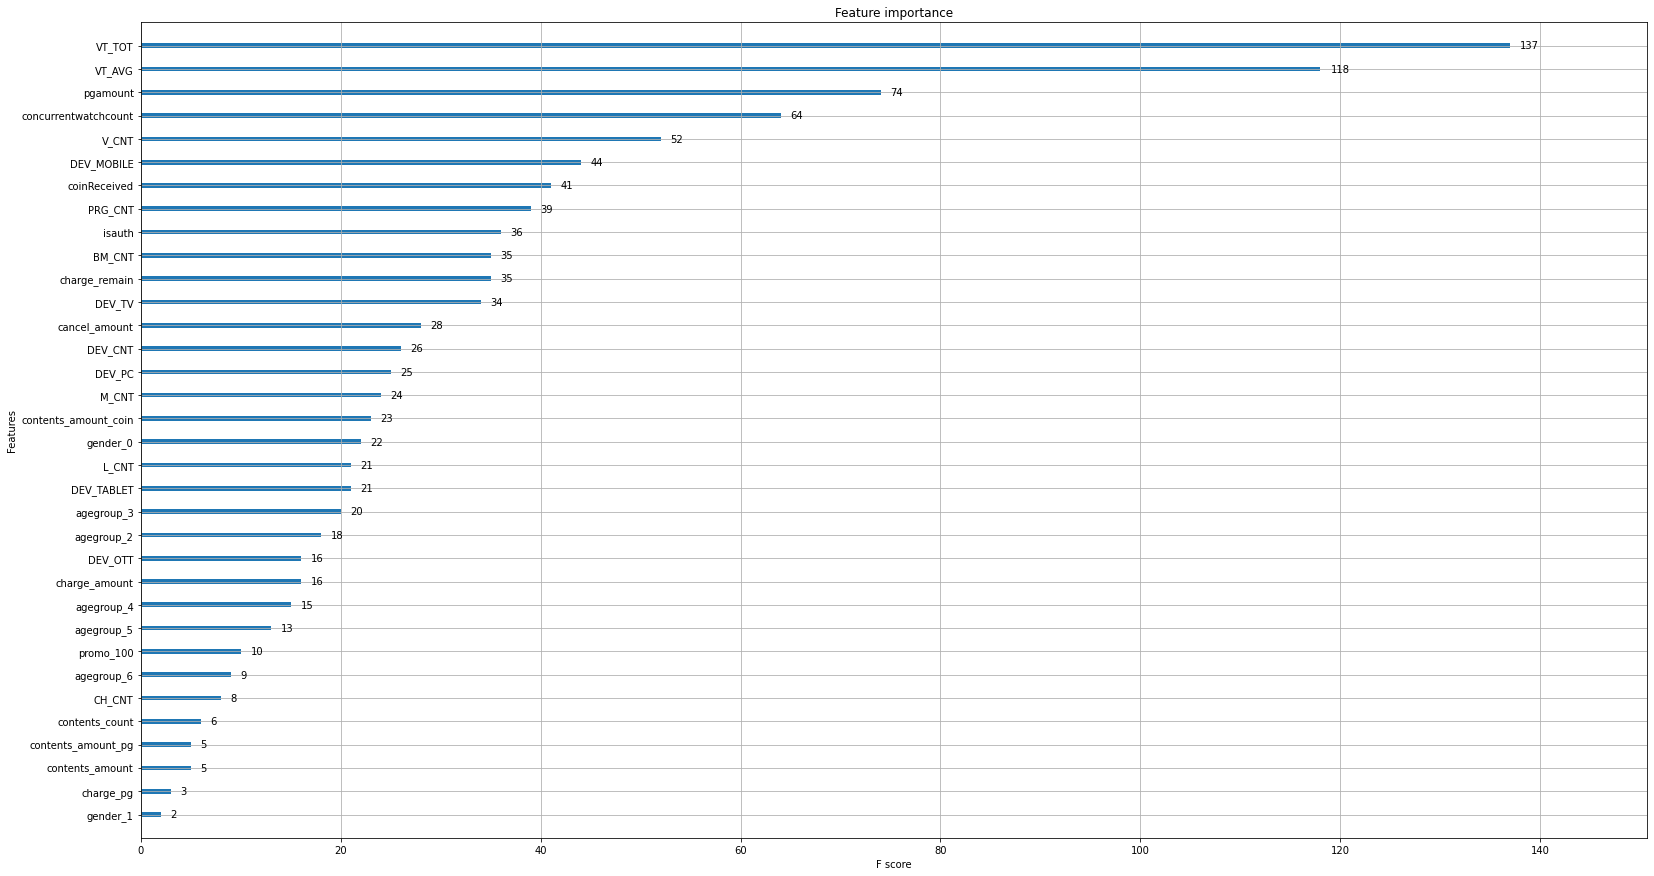

In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_importance
 
fig,ax = plt.subplots(1,1,figsize=(27,15))
plot_importance(xgb, ax)

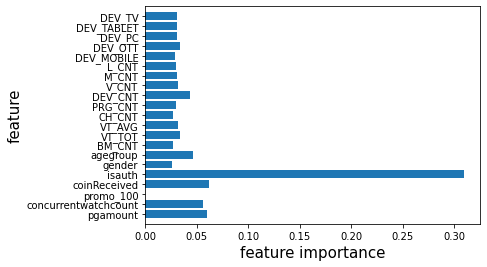

In [ ]:
n_feature = X_train.shape[1]
index = np.arange(n_feature)

plt.barh(index, model.feature_importances_, align='center')
plt.yticks(index, X_train.columns)
plt.ylim(-1, n_feature)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance
r = permutation_importance(rf, X_test, y_test,
                           n_repeats=30,
                           random_state=0)


NameError: ignored

In [ ]:

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_train.columns[i]:<8} "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

isauth   0.036 +/- 0.002
pgamount 0.020 +/- 0.002
agegroup 0.019 +/- 0.002
concurrentwatchcount 0.012 +/- 0.002
promo_100 0.010 +/- 0.001
coinReceived 0.006 +/- 0.001
